In [48]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [49]:
def extract_sample_number(file_name):
    match = re.search(r'sample #(\d+)', file_name)
    if match:
        return int(match.group(1))
    # Return a large number to push files without sample numbers to the end
    return float('inf')

def data_SDR(path_folder):
    # List all files in the folder
    file_list = os.listdir(path_folder)

    # Sort files by sample number
    sorted_file_list = sorted(file_list, key=extract_sample_number)

    # Initialize data matrix based on the sorted file list
    exploration_path = os.path.join(path_folder, sorted_file_list[0])
    data_exploration = np.load(exploration_path)
    
    # Check if the data is complex
    is_complex = np.iscomplexobj(data_exploration)
    
    # Initialize the data matrix with the correct dtype
    data_matrix = np.zeros((len(sorted_file_list), data_exploration.shape[0]), dtype=complex if is_complex else float)

    # Load all files into data_matrix
    for pos, file_name in enumerate(sorted_file_list):
        full_path = os.path.join(path_folder, file_name)
        data = np.load(full_path)
        #print(f"Loading {file_name} (sample #{extract_sample_number(file_name)}), shape = {data.shape}")
        data_matrix[pos] = data

    print("Data matrix loading complete.")
    return data_matrix

In [50]:
path_file_folder = r'C:\Samples-Hack-RF'
data_matrix = data_SDR(path_file_folder)

r_signal = data_matrix[6]

fs = 20e6  # Frecuencia de muestreo (ajustar a la frecuencia de muestreo de tu SDR)
time_sample = 0.01  # Duración total en segundos
num_samples = int(fs * time_sample)
t = np.linspace(0, time_sample, num_samples)

Data matrix loading complete.


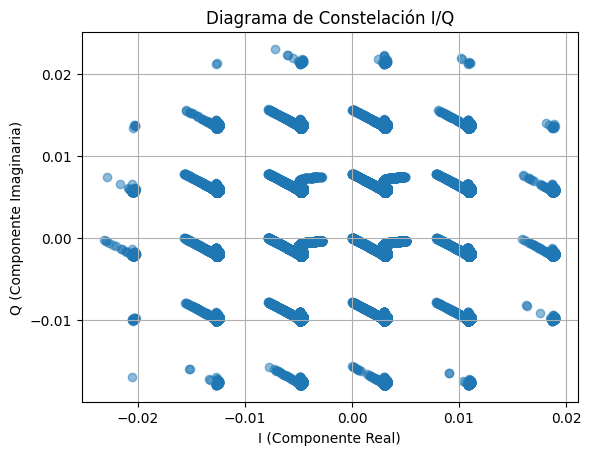

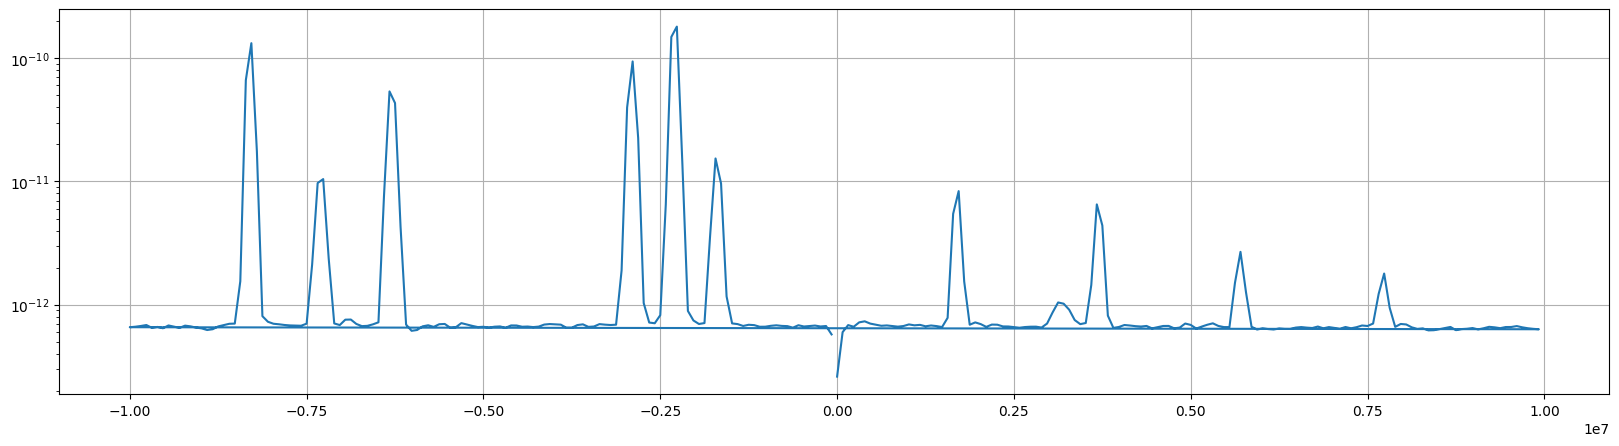

In [52]:
f, Pxx = scipy.signal.welch(r_signal, fs, scaling='density')
plt.scatter(r_signal.real, r_signal.imag, alpha=0.5)
plt.title('Diagrama de Constelación I/Q')
plt.xlabel('I (Componente Real)')
plt.ylabel('Q (Componente Imaginaria)')
plt.grid(True)
plt.show()
plt.figure(figsize=(20,5))
plt.semilogy(f, Pxx)
plt.grid()
plt.show()

RMS de la señal recibida: 0.009176775900388075
Nivel estimado de ruido: 6.451988859672833e-13
Picos detectados en las frecuencias: [ 1699218.75  3691406.25  5703125.   -8300781.25 -7304687.5  -6308593.75
 -2910156.25 -2304687.5  -1699218.75] Hz


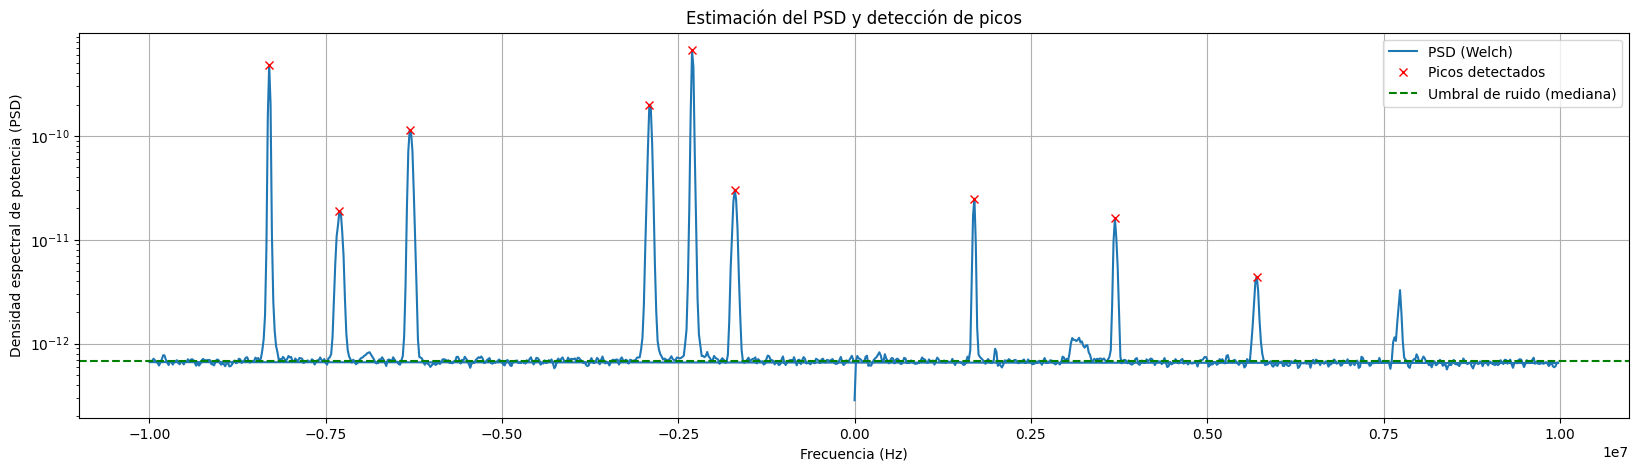

In [53]:
# 3. Calcular el RMS de la señal
rms_value = np.sqrt(np.mean(np.abs(r_signal) ** 2))
print(f"RMS de la señal recibida: {rms_value}")

# 4. Calcular el PSD usando el método de Welch
f, Pxx = scipy.signal.welch(r_signal, fs=fs, nperseg=1024, scaling='density')

# 5. Estimar el nivel de ruido como la mediana del PSD
noise_threshold = np.median(Pxx)
noise_level = np.mean(Pxx[Pxx < noise_threshold])
print(f"Nivel estimado de ruido: {noise_level}")

# 6. Detectar picos en el espectro
peaks, properties = scipy.signal.find_peaks(Pxx, height=noise_threshold * 5)
print(f"Picos detectados en las frecuencias: {f[peaks]} Hz")

# 7. Graficar el PSD y los picos detectados
plt.figure(figsize=(20, 5))
plt.semilogy(f, Pxx, label='PSD (Welch)')
plt.semilogy(f[peaks], properties["peak_heights"], 'rx', label='Picos detectados')  # Marcar los picos
plt.axhline(noise_threshold, color='green', linestyle='--', label='Umbral de ruido (mediana)')
plt.title('Estimación del PSD y detección de picos')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral de potencia (PSD)')
plt.grid()
plt.legend()
plt.show()